## to explore

15min has better correlations to daily returns
15min created with tbbo data
target consisting of moving ma components, which has a memory
by retraining the model you are learning the ma and preserving the ma memory

FEATURE DEV:
  * anchored daily vwap
  * anchored daily ma (14)
  * just ma as features
  * forward looking MA as target (https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60)
  * on MA as features/targets https://chatgpt.com/c/672d03bf-ded4-8013-8349-330786edc44f
  * https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60 
  * SLOPE of MA
  * divergence(DIST MA vs close), as target variable
  * maybe use imbalance columns
  * add MA on returns as additional features

figure out how to turn to signals

* enhance feature
  * try add number of trades, inbalance columns into features
  * try process use tbbo data for aggregation and use bbo data in ohlcv bars and build features upon it https://databento.com/docs/examples/basics-historical/midprice/example
  * datetime features?
* also keep idea of retreain the model frequently even intraday or find working interval (30+1)

This creates features and tests the model and output features to csv. Upon this csv prediction potential can be checked with other notebook and also cgb reg a class run.

Feature definition class

## start from here

* something wrong with this class, the results are not as precise as before with same data
* then try to add additional features see above into subclass below

### target
* also use delta X bars ago and then creates MA of that and use it as a target.
jayjay s formula:

```python
df["target"] = ((np.log(df['Close'].shift(-3))) - np.log(df['Close])) / abs(np.log(df['Close']).shift(-3))

# or MA:
# no rolling
# it's one or the other
# Simple point-to-point slope calculation
df['slope'] = (np.log(df['close'].shift(-3)) - np.log(df['close'])) / 3



# 1. Calculate past-only slope
df['slope'] = (np.log(df['close']) - np.log(df['close'].shift(3))) / 3

# 2. Apply EWM to the slope
df['slope_ewm5'] = df['slope'].ewm(span=5, adjust=False).mean()
df['slope_ewm10'] = df['slope'].ewm(span=10, adjust=False).mean()
df['slope_ewm20'] = df['slope'].ewm(span=20, adjust=False).mean()

# 3. Create future targets
df['future_ewm5'] = df['slope_ewm5'].shift(-1)
df['future_ewm10'] = df['slope_ewm10'].shift(-1)

#feat engineering tips
# EWM differences
df['ewm_diff'] = df['slope_ewm5'] - df['slope_ewm20']

# EWM crossovers
df['ewm_cross'] = np.sign(df['ewm_diff']) != np.sign(df['ewm_diff'].shift(1))

# EWM momentum
df['ewm_momentum'] = df['slope_ewm5'] / df['slope_ewm20'] - 1

# EWM acceleration
df['ewm_accel'] = df['slope_ewm5'] - df['slope_ewm5'].shift(1)

# Multiple timeframe features
df['ewm_ratio'] = df['slope_ewm5'] / df['slope_ewm20']

# Volatility using EWM
df['ewm_vol'] = df['slope'].ewm(span=10).std()



#FINAL CODE:
def create_ewm_features(df, spans=[5, 10, 20]):
    # Base slope
    df['slope'] = (np.log(df['close']) - np.log(df['close'].shift(3))) / 3
    
    # EWM features
    for span in spans:
        # Level
        df[f'slope_ewm_{span}'] = df['slope'].ewm(span=span, adjust=False).mean()
        
        # Volatility
        df[f'vol_ewm_{span}'] = df['slope'].ewm(span=span).std()
        
        # Future target
        df[f'future_ewm_{span}'] = df[f'slope_ewm_{span}'].shift(-1)
    
    # Cross-span features
    df['ewm_fast_slow_ratio'] = df['slope_ewm_5'] / df['slope_ewm_20']
    df['ewm_mid_slow_ratio'] = df['slope_ewm_10'] / df['slope_ewm_20']
    
    return df
```

In [ ]:
# then add code from enhanced features engineering in FEATURES_ntb

In [56]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class BaseFeatureBuilder(ABC):
    """Abstract base class for feature engineering"""
    
    @abstractmethod
    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Build features from input data"""
        pass
    
    @abstractmethod
    def get_feature_columns(self) -> list:
        """Return list of feature column names"""
        pass
    
    @abstractmethod
    def get_feature_descriptions(self) -> dict:
        """Return descriptions of features"""
        pass

    @abstractmethod
    def create_target(self, df, train_data=None) -> dict:
        """Creates target variables"""
        pass    

class TechnicalFeatureBuilder(BaseFeatureBuilder):
    """Original technical feature implementation from LibraryTradingModel"""
    
    def __init__(self, ma_lengths=[5, 10, 20, 50], model_type='regressor'):
        self.model_type = model_type.lower()
        self.ma_lengths = ma_lengths

    def create_target(self, df, train_data=None):
        """Create target variable based on forward MAs and returns"""
        future_ma_fast = df['close'].shift(-self.forward_bars).rolling(5).mean()
        future_ma_slow = df['close'].shift(-self.forward_bars).rolling(20).mean()
        current_ma_slow = df['close'].rolling(20).mean()
        
        forward_returns = df['close'].shift(-self.forward_bars) / df['close'] - 1
        ma_signal = (future_ma_fast - future_ma_slow) / current_ma_slow
        combined_signal = (ma_signal + forward_returns) / 2
        
        if self.model_type == 'regressor':
            return combined_signal
        
        # Classification logic
        if train_data is None:
            signal_data = combined_signal.dropna()
            percentiles = np.linspace(0, 100, self.n_classes + 1)
            self.class_boundaries = np.percentile(signal_data, percentiles)
            self.class_boundaries = np.unique(self.class_boundaries)
            
            epsilon = 1e-10
            self.class_boundaries[0] -= epsilon
            self.class_boundaries[-1] += epsilon
            
            print("\nClass Boundaries Distribution:")
            for i in range(len(self.class_boundaries)-1):
                count = ((signal_data >= self.class_boundaries[i]) & 
                        (signal_data < self.class_boundaries[i+1])).sum()
                pct = count / len(signal_data) * 100
                print(f"Class {i}: {self.class_boundaries[i]:.8f} to {self.class_boundaries[i+1]:.8f} "
                    f"(count: {count}, {pct:.2f}%)")
        
        classes = pd.cut(combined_signal, 
                        bins=self.class_boundaries, 
                        labels=range(self.n_classes),
                        include_lowest=True)
        
        return classes

    def prepare_features(self, df):
        features = df.copy()
        
        # Original features
        features['log_return'] = np.log(features['close'] / features['close'].shift(1))
        features['returns_1'] = features['close'].pct_change()
        features['returns_5'] = features['close'].pct_change(5)
        features['returns_20'] = features['close'].pct_change(20)
        
        # MA-based features
        for length in self.ma_lengths:
            # Regular MAs
            features[f'ma_{length}'] = features['close'].rolling(length).mean()
            
            # MA slopes (rate of change)
            features[f'ma_{length}_slope'] = features[f'ma_{length}'].pct_change(3)
            
            # Price distance from MA
            features[f'price_ma_{length}_dist'] = (features['close'] - features[f'ma_{length}']) / features[f'ma_{length}']
            
            # MA crossovers
            if length > 5:
                features[f'ma_5_{length}_cross'] = (features['ma_5'] - features[f'ma_{length}']) / features[f'ma_{length}']
        
        # MA convergence/divergence
        features['ma_convergence'] = ((features['ma_5'] - features['ma_20']).abs() / 
                                    features['ma_20'].rolling(10).mean())
        
        # Volatility features using MAs
        features['ma_volatility'] = features['ma_5'].rolling(10).std() / features['ma_20']
        
        # MA momentum
        features['ma_momentum'] = (features['ma_5'] / features['ma_5'].shift(5) - 1) * 100
        
        return features.dropna()
    
    def get_feature_columns(self):
        base_features = ['log_return', 'returns_1', 'returns_5', 'returns_20', 'close']
        
        ma_features = []
        for length in self.ma_lengths:
            ma_features.extend([
                f'ma_{length}_slope',
                f'price_ma_{length}_dist'
            ])
            if length > 5:
                ma_features.append(f'ma_5_{length}_cross')
        
        additional_features = [
            'ma_convergence',
            'ma_volatility',
            'ma_momentum'
        ]
        
        return base_features + ma_features + additional_features
    
    def get_feature_descriptions(self):
        descriptions = {
            'log_return': 'Log return of close price',
            'returns_1': '1-day price return',
            'returns_5': '5-day price return',
            'returns_20': '20-day price return',
            'ma_convergence': 'Convergence/divergence of fast and slow MAs',
            'ma_volatility': 'Volatility based on MA movement',
            'ma_momentum': 'Momentum of fast MA'
        }
        
        for length in self.ma_lengths:
            descriptions.update({
                f'ma_{length}': f'{length}-period Moving Average',
                f'ma_{length}_slope': f'Slope of {length}-period MA',
                f'price_ma_{length}_dist': f'Price distance from {length}-period MA'
            })
            if length > 5:
                descriptions[f'ma_5_{length}_cross'] = f'Crossover between 5 and {length}-period MAs'
                
        return descriptions

In [28]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

class LibraryTradingModel:
    def __init__(self, feature_builder=None, train_days=10, test_days=1, forward_bars=5, 
                 n_classes=5, model_type='classifier'):
        """
        Initialize the trading model with a feature builder.
        
        Parameters:
        feature_builder (BaseFeatureBuilder): Feature engineering implementation
        train_days (int): Number of days for training window
        test_days (int): Number of days for testing window
        forward_bars (int): Number of bars to look ahead for returns
        n_classes (int): Number of classes for classifier (ignored for regressor)
        model_type (str): Either 'classifier' or 'regressor'
        """
        self.feature_builder = feature_builder or TechnicalFeatureBuilder()
        self.train_days = train_days
        self.test_days = test_days
        self.forward_bars = forward_bars
        self.n_classes = n_classes
        if self.model_type not in ['classifier', 'regressor']:
            raise ValueError("model_type must be either 'classifier' or 'regressor'")
        self.scaler = StandardScaler()
        self.class_boundaries = None

    def get_date_windows(self, data):
        """
        Calculate date windows for training and testing.
        Handles any frequency of data by using datetime index.
        
        Returns:
        List of tuples: (train_start, train_end, test_start, test_end)
        """
        # Convert days to timedelta
        train_delta = timedelta(days=self.train_days)
        test_delta = timedelta(days=self.test_days)
        
        start_date = data.index[0]
        end_date = data.index[-1]
        
        windows = []
        current_start = start_date
        
        while True:
            train_end = current_start + train_delta
            test_start = train_end
            test_end = test_start + test_delta
            
            # Break if we've reached the end of data
            if test_end > end_date:
                break
                
            windows.append((current_start, train_end, test_start, test_end))
            current_start = current_start + timedelta(days=self.test_days)  # Move forward by test period
            
        return windows

    def display_results(self, y_true, y_pred, title, probabilities=None):
        """Display results based on model type"""
        if self.model_type == 'classifier':
            self._display_confusion_matrix(y_true, y_pred, title, probabilities)
        else:
            self._display_regression_results(y_true, y_pred, title)

    def _display_regression_results(self, y_true, y_pred, title):
        """Display regression results with actual vs predicted plot"""
        plt.figure(figsize=(10, 6))
        
        # Scatter plot of actual vs predicted
        plt.scatter(y_true, y_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted: {title}')
        plt.legend()
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"\nRegression Metrics for {title}:")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R²: {r2:.6f}")
        
        plt.show()

    def _display_confusion_matrix(self, y_true, y_pred, title, probabilities=None):
        """Display confusion matrix for classification results"""
        cm = confusion_matrix(y_true, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        labels = [[f'{int(cm[i, j])}\n{cm_percent[i, j]:.1f}%' 
                  if cm[i, j] > 0 else ''
                  for j in range(len(cm))]
                 for i in range(len(cm))]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
        plt.title(f'Confusion Matrix: {title}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        print("\nPer-class metrics:")
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        metrics_df = pd.DataFrame({
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }, index=[f'Class {i}' for i in range(self.n_classes)])
        
        print(metrics_df.round(3))
        print(f"\nOverall Accuracy: {np.sum(np.diag(cm)) / np.sum(cm):.3f}")

    def run_iteration(self, train_data, test_data, iteration_num):
        """Run a single iteration of training and testing"""
        if self.model_type == 'classifier':
            model = XGBClassifier(n_estimators=100, random_state=42)
        else:
            model = XGBRegressor(n_estimators=100, random_state=42)
        
        try:
            self.class_boundaries = None
            
            print(f"\nProcessing iteration {iteration_num}")
            print(f"Training data: {train_data.index[0]} to {train_data.index[-1]}")
            print(f"Test data: {test_data.index[0]} to {test_data.index[-1]}")
            
            # Combine data for feature calculation #TODO potentially do train data vs (warm up period data) + test data
            combined_data = pd.concat([train_data, test_data]).sort_index()
            features_df = self.feature_builder.prepare_features(combined_data)
            
            # Split back into train and test after feature calculation
            train_features = features_df[features_df.index.isin(train_data.index)]
            test_features = features_df[features_df.index.isin(test_data.index)]
            
            # Prepare training data
            train_target = self.create_target(train_features)
            feature_cols = self.feature_builder.get_feature_columns()
            
            X_train = train_features[feature_cols]
            y_train = train_target
            
            # Remove NaN values
            mask_train = ~y_train.isna()
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
            
            if len(X_train) < self.forward_bars + 1:
                print(f"Warning: Iteration {iteration_num} - Insufficient training data")
                return None, None
                
            print(f"Training samples after preparation: {len(X_train)}")
            
            if self.model_type == 'classifier':
                # Check class distribution for classifier
                class_dist = y_train.value_counts(normalize=True).sort_index()
                print(f"Class distribution in training:")
                print(class_dist)
                
                # Handle missing classes for classifier
                missing_classes = set(range(self.n_classes)) - set(class_dist.index)
                if missing_classes:
                    print(f"\nWARNING: Missing classes in training data: {missing_classes}")
                    print("Adjusting model to handle missing classes...")
                    for missing_class in missing_classes:
                        X_train = pd.concat([X_train, X_train.iloc[[0]]])
                        y_train = pd.concat([y_train, pd.Series([missing_class], index=[X_train.index[-1]])])
            
            # Scale features
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Prepare test data using the same scaler
            X_test = test_features[feature_cols]
            y_test = self.create_target(test_features, train_data=train_features)
            
            X_test_scaled = self.scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            
            # Make predictions
            predictions = model.predict(X_test_scaled)
            
            # Create results DataFrame
            results = pd.DataFrame({
                'predicted': predictions,
                'actual': y_test
            }, index=X_test.index)
            
            # Add probability columns for classifier
            if self.model_type == 'classifier':
                probabilities = model.predict_proba(X_test_scaled)
                if probabilities.shape[1] != self.n_classes:
                    raise ValueError(f"Probability matrix has wrong shape: {probabilities.shape}")
                
                for i in range(self.n_classes):
                    results[f'prob_class_{i}'] = probabilities[:, i]
            
            # Display results if we have valid test samples
            mask = ~results['actual'].isna()
            if mask.any():
                print(f"\nValid test samples: {mask.sum()}")
                if self.model_type == 'classifier':
                    self.display_results(
                        results.loc[mask, 'actual'],
                        results.loc[mask, 'predicted'],
                        f'Iteration {iteration_num}',
                        probabilities=probabilities[mask] if self.model_type == 'classifier' else None
                    )
                else:
                    self.display_results(
                        results.loc[mask, 'actual'],
                        results.loc[mask, 'predicted'],
                        f'Iteration {iteration_num}'
                    )
            
            return results, model
            
        except Exception as e:
            print(f"Error in iteration {iteration_num}: {str(e)}")
            print(f"Training data shape: {train_data.shape}")
            print(f"Test data shape: {test_data.shape}")
            return None, None

    def run_rolling_window(self, data, num_iterations=None):
        """Run the model using a rolling window approach"""
        windows = self.get_date_windows(data)
        
        if num_iterations is not None:
            windows = windows[:num_iterations]
        
        all_results = {}
        all_predictions = []
        all_actuals = []
        
        for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
            train_mask = (data.index >= train_start) & (data.index < train_end)
            test_mask = (data.index >= test_start) & (data.index < test_end)
            
            train_data = data[train_mask]
            test_data = data[test_mask]
            
            min_required_bars = max(20, self.forward_bars + 1)
            if len(train_data) < min_required_bars or len(test_data) < 1:
                print(f"Skipping iteration {i}: Insufficient data (train: {len(train_data)}, test: {len(test_data)} bars)")
                continue
            
            results, model = self.run_iteration(train_data, test_data, i)
            
            if results is not None:
                all_results[i] = {
                    'train_period': (train_start, train_end),
                    'test_period': (test_start, test_end),
                    'results': results,
                    'model': model
                }
                
                mask = ~results['actual'].isna()
                if mask.any():
                    all_predictions.extend(results.loc[mask, 'predicted'])
                    all_actuals.extend(results.loc[mask, 'actual'])
        
        if all_predictions:
            print("\n=== Overall Results Across All Iterations ===")
            self.display_results(
                pd.Series(all_actuals),
                pd.Series(all_predictions),
                'All Iterations Combined'
            )
        elif not all_results:
            print("No valid results generated across all iterations.")

        return all_results

    def generate_features_csv(self, data, output_filename, use_raw_target=True, 
                            include_target_components=False, use_generic_features=False):
        """Generate features CSV using the feature builder"""
        try:
            print("Preparing features for entire dataset...")
            
            features_df = self.feature_builder.prepare_features(data)
            feature_cols = self.feature_builder.get_feature_columns()
            
            # Calculate target components
            future_ma_fast = features_df['close'].shift(-self.forward_bars).rolling(5).mean()
            future_ma_slow = features_df['close'].shift(-self.forward_bars).rolling(20).mean()
            current_ma_slow = features_df['close'].rolling(20).mean()
            forward_returns = features_df['close'].shift(-self.forward_bars) / features_df['close'] - 1
            ma_signal = (future_ma_fast - future_ma_slow) / current_ma_slow
            combined_signal = (ma_signal + forward_returns) / 2
            
            if use_generic_features:
                output_df = pd.DataFrame(
                    features_df[feature_cols].values,
                    columns=[f'feature_{i}' for i in range(len(feature_cols))],
                    index=features_df.index
                )
                
                output_df['target'] = combined_signal if use_raw_target else self.create_target(features_df)
                
                if include_target_components:
                    output_df['forward_return'] = forward_returns
                    output_df['ma_signal'] = ma_signal
                    output_df['combined_signal'] = combined_signal
            else:
                output_df = pd.DataFrame(index=features_df.index)
                
                for col in feature_cols:
                    output_df[col] = features_df[col]
                
                output_df['target'] = combined_signal if use_raw_target else self.create_target(features_df)
                if include_target_components:
                    output_df['forward_return'] = forward_returns
                    output_df['ma_signal'] = ma_signal
                    output_df['combined_signal'] = combined_signal
            
            output_df.dropna().to_csv(output_filename, index=True, index_label='Open time')
            
            print(f"\nFeatures generated successfully!")
            print(f"Output saved to: {output_filename}")
            print(f"Total rows: {len(output_df)}")
            print(f"Total features: {len(feature_cols)}")
            
            if not use_generic_features:
                print("\nFeature descriptions:")
                for feat, desc in self.feature_builder.get_feature_descriptions().items():
                    if feat in feature_cols:
                        print(f"{feat}: {desc}")
            else:
                print("\nFeature mapping:")
                for i, original_name in enumerate(feature_cols):
                    print(f"feature_{i}: {original_name}")
            
            return output_df
            
        except Exception as e:
            print(f"Error generating features: {str(e)}")
            raise

In [3]:
import vectorbtpro as vbt
import ttools as tts
#from lightweight_charts import chart, Panel, PlotDFAccessor, PlotSRAccessor
#import talib
import ttools as tts
from ttools.config import DATA_DIR
from ttools.utils import zoneNY, AggType
from ttools.loaders import load_data
from numba import jit
import pandas as pd
import numpy as np
from datetime import datetime
vbt.settings.plotting.auto_rangebreaks = True
vbt.settings.set_theme("dark")
vbt.settings.plotting["use_resampler"] = True

TTOOLS: Loaded env variables from file /Users/davidbrazda/Documents/Development/python/.env


In [49]:
#This is how to call LOAD function
symbol = ["BAC"]
#datetime in zoneNY 
day_start = datetime(2024, 8, 1, 9, 30, 0)
day_stop = datetime(2024, 10, 20, 16, 0, 0)
day_start = zoneNY.localize(day_start)
day_stop = zoneNY.localize(day_stop)

#requested AGG
resolution = 25 #10min bars #12s bars
agg_type = AggType.OHLCV #other types AggType.OHLCV_VOL, AggType.OHLCV_DOL, AggType.OHLCV_RENKO
exclude_conditions = ['C','O','4','B','7','V','P','W','U','Z','F','9','M','6'] #None to defaults
minsize = 100 #min trade size to include
main_session_only = True
force_remote = False

bac_data = load_data(symbol = symbol,
                     agg_type = agg_type,
                     resolution = resolution,
                     start_date = day_start,
                     end_date = day_stop,
                     #exclude_conditions = None,
                     minsize = minsize,
                     main_session_only = main_session_only,
                     force_remote = force_remote,
                     return_vbt = False, #returns vbt object
                     verbose = True
                     )

matched agg files 1

File: BAC-AggType.OHLCV-25-2024-08-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet
Coverage: 2024-08-01 09:30:00 to 2024-10-20 16:00:00
Symbol: BAC
Agg Type: AggType.OHLCV
Resolution: 25
Excludes: 4679BCFMOPUVWZ
Minsize: 100
Main Session Only: True
--------------------------------------------------------------------------------
Loaded from agg_cache /Users/davidbrazda/Library/Application Support/v2realbot/aggcache/BAC-AggType.OHLCV-25-2024-08-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet


Claude https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60

This will generate features and test them (xgbclassifier, with pct class transformation and output as directional confusion matrix)

In [50]:
 

# features_df = model.generate_features_csv(df,
#                                           CSV_FILE_PATH,
#                                           use_raw_target=True,
#                                           include_target_components=False, #include all target components (signal crossover etc.) vs only target
#                                           use_generic_features=False) #label genericly feature_0 or descriptive ma_50   
#                                           #include_ohlcv=True)  #what columns to include from input dataset                                   
                                        




Preparing features for entire dataset...

Features generated successfully!
Output saved to: features_ma_bac_25s.csv
Total rows: 52361
Total features: 19

Feature descriptions:
log_return: Log return of close price
returns_1: 1-day price return
returns_5: 5-day price return
returns_20: 20-day price return
ma_convergence: Convergence/divergence of fast and slow MAs
ma_volatility: Volatility based on MA movement
ma_momentum: Momentum of fast MA
ma_5_slope: Slope of 5-period MA
price_ma_5_dist: Price distance from 5-period MA
ma_10_slope: Slope of 10-period MA
price_ma_10_dist: Price distance from 10-period MA
ma_5_10_cross: Crossover between 5 and 10-period MAs
ma_20_slope: Slope of 20-period MA
price_ma_20_dist: Price distance from 20-period MA
ma_5_20_cross: Crossover between 5 and 20-period MAs
ma_50_slope: Slope of 50-period MA
price_ma_50_dist: Price distance from 50-period MA
ma_5_50_cross: Crossover between 5 and 50-period MAs


In [18]:
features_df.info()
#show rows containing nans
#features_df[features_df.isna().any(axis=1)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13534 entries, 2024-10-10 09:44:12-04:00 to 2024-10-18 15:59:24-04:00
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   log_return        13534 non-null  float64
 1   returns_1         13534 non-null  float64
 2   returns_5         13534 non-null  float64
 3   returns_20        13534 non-null  float64
 4   ma_5_slope        13534 non-null  float64
 5   price_ma_5_dist   13534 non-null  float64
 6   ma_10_slope       13534 non-null  float64
 7   price_ma_10_dist  13534 non-null  float64
 8   ma_5_10_cross     13534 non-null  float64
 9   ma_20_slope       13534 non-null  float64
 10  price_ma_20_dist  13534 non-null  float64
 11  ma_5_20_cross     13534 non-null  float64
 12  ma_50_slope       13534 non-null  float64
 13  price_ma_50_dist  13534 non-null  float64
 14  ma_5_50_cross     13534 non-null  float64
 15  ma_convergence    13534 non-null  float6

In [54]:
df = df.loc["2024-08-01 9:30:00":"2024-08-01 16:00:00"]

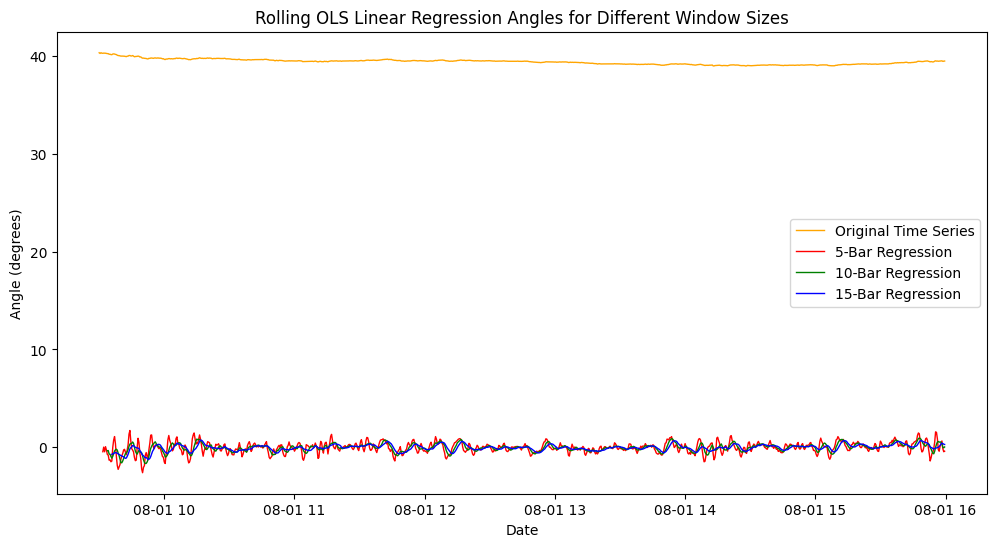

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Function to calculate the rolling regression angle
def rolling_regression_angle(series, window):
    angles = [np.nan] * (window - 1)  # Fill initial values with NaN
    for i in range(window, len(series) + 1):
        y = series[i - window:i]
        x = np.arange(window)  # x values: 0, 1, ..., window-1
        slope, _, _, _, _ = linregress(x, y)
        angle = np.degrees(np.arctan(slope))  # Convert slope to angle in degrees
        angles.append(angle)
    return angles

# Different window sizes for rolling regression
window_sizes = [5, 10, 15]
colors = ['orange', 'red', 'green', 'blue']
labels = ['Original Time Series', '5-Bar Regression', '10-Bar Regression', '15-Bar Regression']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], color=colors[0], label=labels[0], linewidth=1)

# Calculate and plot angles for each window size
for idx, window in enumerate(window_sizes):
    df[f'Regression_Angle_{window}'] = rolling_regression_angle(df['close'], window)
    plt.plot(df.index, df[f'Regression_Angle_{window}'], color=colors[idx+1], label=labels[idx+1], linewidth=1)

# Plot settings
plt.title('Rolling OLS Linear Regression Angles for Different Window Sizes')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Angle (degrees)')
plt.show()
